# **Automatic Labeling of Topics with External Sources (ALTES)**

#Construção dos Tópicos


##Instalação

In [ ]:
# reading daaset from Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# General utilities
!pip install emoji
!pip install simplejson
!pip install wmd
!pip install kneed
!pip install pyyaml==5.4.1

# BERTopic
!pip install bertopic[all]
!pip install umap-learn

# Embedding
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install flair
!pip install fasttext
!pip install --upgrade urllib3
!pip install --upgrade transformers

!pip uninstall numpy
!pip install 'numpy>=1.18.0,<1.23.0'
!pip install compress-fasttext

# Wikipedia
!pip install wikipedia-api

In [ ]:
# Packages to store and manipulate data
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import math
import os
import json
import csv
import string
import glob
import random
import time
from datetime import datetime
import requests
from collections import Counter

# Plotting packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Gensim
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim import models
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
import gensim.downloader as api

# SciPy
from scipy import spatial
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, issparse
from spacy.lang.en.stop_words import STOP_WORDS

# SciKit-Learn
import sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, pairwise_kernels, cosine_similarity
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

# NLP Packages
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk import bigrams
from nltk.util import ngrams
from nltk import RegexpParser
from nltk.corpus import brown
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
import spacy
import re
import requests

# Keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, GRU, Dropout, Reshape, Bidirectional
from keras.callbacks import Callback, ModelCheckpoint

# Other Packages
import emoji
import operator
from operator import itemgetter
from tqdm import tqdm
from collections import defaultdict
import multiprocessing
from pprint import pprint
import simplejson as json
import wmd
#import umap
from umap import UMAP
from hdbscan import HDBSCAN
from kneed import KneeLocator
import fasttext

# BERTopic and Embeddings
from bertopic import BERTopic
from bertopic.backend import WordDocEmbedder
from sentence_transformers import SentenceTransformer
from flair.embeddings import TransformerDocumentEmbeddings
from flair.embeddings import TransformerWordEmbeddings

# Compression of fasttext models
import compress_fasttext
small_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/gensim-4-draft/ft_cc.en.300_freqprune_400K_100K_pq_300.bin'
)

# Natural Language Toolkit
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Spacy
nlp = spacy.load('en_core_web_sm')

# Set options for pandas
pd.set_option('max_colwidth', 200)

# Include if using a notebook
%matplotlib inline

##Importação dos Dados

In [17]:
import pandas as pd

# Define the text processing function
def process_text(tweet):
    tweet_len = [word for word in tweet.split(' ') if len(word) >= 3]
    return ' '.join(tweet_len)

# Load the data
df_dados = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Dissertação/Dados_temporais_processados/Fins_de_semana/dados_fevereiro_sem_emoji_fim_de_semana_2.json')

# Remove unnecessary columns
df_dados = df_dados.drop(columns=['created_at', 'id'])

# Apply the text processing function
df_dados['clean_tweet'] = df_dados['clean_tweet'].apply(process_text)

df_dados

,tweet,clean_tweet
0,I don’t know. It’s ok. I’m over sensitized. - Drinking a Double Blizzard by @TroegsBeer @ Lizardville Beer Store &amp; Whiskey Bar — https://t.co/Tj7XOfR9t4,know sensitized drinking double blizzard lizardville beer store whiskey bar
1,Angelica's 7day Forecasts:\nSunny and Warm Weather Through The Weekend.\nAnother batch of rain showers and mountain snow Tuesday-Wednesday! #sdwx @10News @10NewsCampos https://t.co/J9DfhBgCaB,angelica day forecasts sunny warm weather weekend another batch rain showers mountain snow tuesday wednesday
2,"Wisconsin is always improving my vocabulary. One year I learned the term polar vortex, now I’ve learned what a snow squall is. Love to see it.",wisconsin improving vocabulary year learned term polar vortex learned snow squall love
3,"Heavy, lake effect snow squalls pummeling Houghton, MI right now!! #906wx #StormHour #KeweenawPeninsula https://t.co/TPy1HLCKny",heavy lake effect snow squalls pummeling houghton right
4,"Currently, it's a sunny and pleasant end to the work week &amp; 63 Degrees in Downtown San Diego! #sdwx @10News @10NewsCampos https://t.co/65YY1zr73R",currently sunny pleasant end work week degrees downtown san diego
...,...,...
26903,I’m sick and stressed so I went down the rabbit hole of the new season of Love Is Blind and woof — this is very bad 😝☠️🤪 #andIcantstopwatching https://t.co/ThSHRFxBhq,sick stressed went rabbit hole season love blind woof bad
26904,My anxiety watching this is through the roof #Daytona500,anxiety watching roof
26905,Wonderful weekend celebrating Golisano Children’s Museum of Naples @childrensmuseumofnaples and Children’s National Hospital @childrensnational…❤️❤️❤️ @ Children's Museum of Naples https://t.co/7G...,wonderful weekend celebrating golisano children museum naples children national hospital children museum naples
26906,"These past few days I’ve just been going off vibes because if I didn’t, this heartbreak would be the death of me. https://t.co/ZbuY5T8YB4",past days going vibes heartbreak death


##Modelagem de Tópico

In [18]:
# UMAP model setup
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Word embedding model setup
embedding_word = TransformerWordEmbeddings('roberta-large')

# Document embedding model setup
embedding_document = SentenceTransformer('all-mpnet-base-v2')

# Create a model that uses both language models and pass it through BERTopic
word_doc_embedder = WordDocEmbedder(embedding_model=embedding_document, word_embedding_model=embedding_word)

In [19]:
# Fit and transform the data with the BERTopic model
topic_model = BERTopic(nr_topics="auto", language='english', calculate_probabilities=True,
                       embedding_model=word_doc_embedder, umap_model=umap_model, verbose=True)

# Training the model on clean tweets
topics, probabilities = topic_model.fit_transform(list(df_dados.clean_tweet))

Batches:   0%|          | 0/840 [00:00<?, ?it/s]

2023-09-26 18:09:36,540 - BERTopic - Transformed documents to Embeddings
2023-09-26 18:10:40,957 - BERTopic - Reduced dimensionality
2023-09-26 18:12:41,227 - BERTopic - Clustered reduced embeddings
2023-09-26 18:12:43,957 - BERTopic - Reduced number of topics from 306 to 191


##Tópicos

In [110]:
# Extracting information about the topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,10779,-1_basketball_church_game_love,"[basketball, church, game, love, today, like, couple, time, good, jesus]","[bad let switch years star saturday night, snow squall tonight sunday hate state, basketball weekend continues start saturday morning grade boys basketball star games]"
1,0,1822,0_wordle_word_words_nyt,"[wordle, word, words, nyt, streak, guess, letters, fuck, today, guesses]","[wordle, wordle, wordle]"
2,1,761,1_ukraine_russia_putin_russian,"[ukraine, russia, putin, russian, nato, invade, invasion, biden, war, military]","[ukraine, ukraine, ukraine russia]"
3,2,745,2_snow_reports_inch_squall,"[snow, reports, inch, squall, cocorahs, near, heavy, public, station, observer]","[snow squall, snow squall snow squall, snow squall]"
4,3,663,3_nascar_race_daytona_lap,"[nascar, race, daytona, lap, racing, pit, cars, car, caution, laps]","[nascar sunday, watching nascar race day today fox, race day]"
...,...,...,...,...,...
186,185,10,185_trail_hike_crosses_miles,"[trail, hike, crosses, miles, dominion, vienna, hiking, metro, canyon, washington]","[annual cross charlotte trail update ran miles ballantyne noda breakfast stream crossings mud time years ago, trail crosses metro miles downtown vienna beautiful sunny morning washington old domin..."
187,186,10,186_spotr_utc_blowing_miles,"[spotr, utc, blowing, miles, snow, drifting, covered, visibility, ene, lockport]","[spotr miles ene lake geneva utc snow snow hour total snow depth snow blowing road snow covered, spotr miles lockport utc snow snow blowing drifting road snow covered, spotr miles lockport utc sno..."
188,187,10,187_hours_scholz_consult_demon,"[hours, scholz, consult, demon, hrs, celebrating, office, working, hour, tomorrow]","[hours, hours, scholz consult hours]"
189,188,10,188_kiss_chef_chefs_depths,"[kiss, chef, chefs, depths, dongju, levi, keonhee, twas, erwin, propose]","[walk chef kiss, night chef kiss, chef kiss]"


In [111]:
# Extracting information about the topics
topic_model.get_topic_info(4)

,Topic,Count,Name,Representation,Representative_Docs
0,4,564,4_basketball_boys_girls_varsity,"[basketball, boys, girls, varsity, final, state, tournament, congratulations, soccer, round]","[varsity basketball boys end quarter north little rock bryant, varsity basketball girls end quarter north little rock bryant, varsity basketball girls final north little rock bryant]"


In [112]:
# Visualize the topics in a 2D space
topic_model.visualize_topics()

In [113]:
# Visualize the topic sizes in a bar chart
topic_model.visualize_barchart()

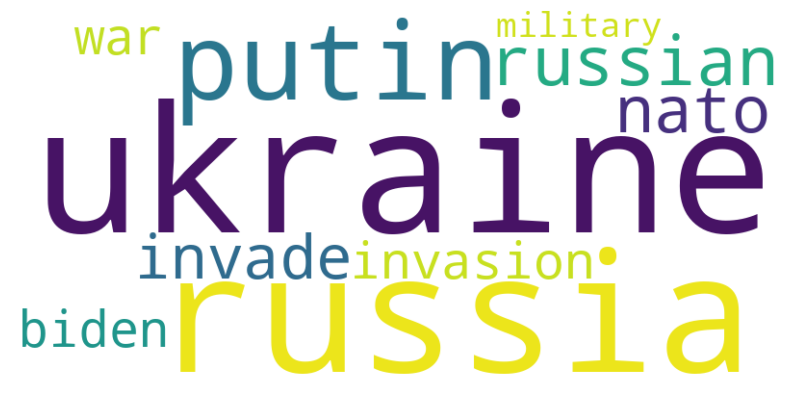

In [140]:
# Define the topic number you want to visualize
topic_number = 1

# Get the most representative words for the specified topic
topic_words = topic_model.get_topic(topic_number)

# Transform the topic words into a dictionary with words as keys and weights as values
topic_dict = {word: weight for word, weight in topic_words}

# Configure the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=100, contour_color='steelblue')

# Generate the word cloud
wordcloud.generate_from_frequencies(topic_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [141]:
# Obtendo informações do tópico
topic = topic_model.get_topic_info(topic_number)

# Obtendo a representação do tópico
list_topic = topic["Representation"]

# Transformando a representação do tópico em uma lista de palavras
list_word_topic = [word for sublist in list_topic for word in sublist]

# Imprimindo a lista de palavras do tópico
print(list_word_topic)

['ukraine', 'russia', 'putin', 'russian', 'nato', 'invade', 'invasion', 'biden', 'war', 'military']


#Rotulação dos Tópicos

##Coletando Títulos de Artigos

In [142]:
# For Topic 1
keywords = list_word_topic

def find_articles_with_keywords(keywords):
    search_url = "https://en.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "format": "json",
        "list": "search",
        "srsearch": " ".join(keywords),
        "srprop": "titlesnippet",
        "srinfo": "totalhits",
        "srlimit": 1000  # Define the maximum number of results
    }

    # Make a request to the Wikipedia API
    response = requests.get(search_url, params=params)
    data = response.json()

    matching_articles = []
    cont = 0
    if "query" in data and "search" in data["query"]:
        for result in data["query"]["search"]:
            title_input = result["title"]
            title = re.sub('([0-9]+)', '', title_input)  # Removing numbers

            punctuation = '#!"…¨$%&\'”’(“)*+_,-./:;<=>?[\\]^_`{|}~•@'
            title = re.sub('['+punctuation+']+', ' ', title) # Removing punctuation

            stop_words = stopwords.words('english') # Removing stopwords
            stop_words.extend(keywords) # Removing keywords
            stop_words.extend(['list', 'redirect', 'category', 'section', 'from']) # Removing specific terms from Wikipedia
            stop_words.extend(['s', 're', 'm', 'd', 've', 'll']) # Removing abbreviations

            words = title.split()
            filtered_words = [word for word in words if word.lower() not in stop_words]
            title = ' '.join(filtered_words)

            if cont < 20:
              if len(filtered_words) > 1:
                cont += 1
                matching_articles.append(title_input)

    return matching_articles

matching_articles = find_articles_with_keywords(keywords)

df_label_title = pd.DataFrame(matching_articles, columns=['Article Title'])
#print(df_label_title)

In [151]:
from IPython.display import display, HTML
matching_articles = find_articles_with_keywords(keywords)
html = "<ol>"
for article_title in matching_articles:
    html += f"<li><a href='https://en.wikipedia.org/wiki/{article_title.replace(' ', '_')}'>{article_title}</a></li>"
html += "</ol>"
display(HTML(html))

##Preparação dos Títulos de Artigos

In [144]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd

class TitleProcessor:
    def __init__(self, dataframe, stopword_extensions = [], punctuation = '#!"…¨$%&\'”’(“)*+_,-.–/_:;<=>?[\\]^_`{|}~•@'):
        self.dataframe = dataframe.copy()
        self.stop_words = self.get_extended_stopwords(stopword_extensions)
        self.punctuation = punctuation
        self.process_title()

    def process_title(self):
        self.dataframe['clean_title'] = self.dataframe['Article Title'].apply(self.clean_text)

    def clean_text(self, text):
        text = self.lower_text(text)
        text = self.remove_punctuation(text)
        text = self.remove_double_spacing(text)
        text = self.remove_numbers(text)
        text = self.tokenize_remove_stopwords_lemmatize(text)
        return ' '.join(text)

    def lower_text(self, text):
        return text.lower()

    def remove_punctuation(self, text):
        return re.sub(f'[{self.punctuation}]+', ' ', text)

    def remove_double_spacing(self, text):
        return re.sub(r'\s+', ' ', text)

    def remove_numbers(self, text):
        return re.sub('([0-9]+)', '', text).strip()

    def tokenize_remove_stopwords_lemmatize(self, text, bigrams=False):
        lemmatiser = WordNetLemmatizer()
        return [lemmatiser.lemmatize(word) for word in text.split() if len(word) > 2 and word not in self.stop_words]

    def get_extended_stopwords(self, extensions):
        stop_words = stopwords.words('english')
        stop_words.extend(extensions)
        return stop_words

    def get_tokens_set(self):
        tokens = []
        for title in self.dataframe['clean_title']:
            tokens.extend(title.split())
        return tokens

    def get_dataframe(self):
        return self.dataframe.dropna(subset=['clean_title'])


#df_label_title = pd.read_csv("...", index_col=False, dtype='unicode')

stopword_extensions = ['list', 'redirect', 'category', 'section', 'from','s', 're', 'm', 'd', 've', 'll'] + keywords

title_processor = TitleProcessor(df_label_title, stopword_extensions)

df_label = title_processor.get_dataframe()
tokens = title_processor.get_tokens_set()

df_label

,Article Title,clean_title
0,Russo-Ukrainian War,russo ukrainian
1,Timeline of the Russian invasion of Ukraine (8 June 2023 – present),timeline june present
2,Ukraine–NATO relations,relation
3,NATO–Russia relations,relation
4,International sanctions during the Russian invasion of Ukraine,international sanction
5,Government and intergovernmental reactions to the Russian invasion of Ukraine,government intergovernmental reaction
6,Russia–Ukraine relations,relation
7,List of military aid to Ukraine during the Russo-Ukrainian War,aid russo ukrainian
8,Foreign involvement in the Russian invasion of Ukraine,foreign involvement
9,International sanctions during the Russo-Ukrainian War,international sanction russo ukrainian


##Seleção das Palavras dos Títulos de Artigo

In [145]:
# Counts the total occurrences of each word
word_counts = Counter(word for title in df_label.clean_title for word in title.split())
print("Size of Vocabulary:", len(word_counts))

word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])
word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)
# Displays the most frequent words
print(word_counts_df.head(10))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_label.clean_title)
word_index = tokenizer.word_index

Size of Vocabulary: 31
             Word  Count
0           russo      4
2        timeline      4
1       ukrainian      4
5        relation      4
7        sanction      2
14         united      2
15          state      2
6   international      2
3            june      2
20       occupied      1


In [146]:
# Initialize an empty list to hold the filtered tokens
new_tokens = []

# Loop over each token in the original list
for t in tokens:
    # Define the part-of-speech types we're interested in keeping
    types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')

    # Use nltk's part-of-speech tagger to tag the current token
    tag = nltk.pos_tag([t])

    # If the token's part-of-speech is in our list of types, append it to our new list
    if tag[0][1] in types:
        new_tokens.append(t)

# Check the length of the new list of tokens
len(new_tokens)
# Uncomment the next line if you want to print the new tokens
#new_tokens

46

##Construção dos Candidatos a Rótulo

In [147]:
# Define bigram and trigram measures
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

# Set up bigram and trigram finders
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(new_tokens)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(new_tokens)

# Find and tabulate bigrams and trigrams by frequency
bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

trigram_freq = trigramFinder.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)

# Define stopwords in English
stopwords_en = set(stopwords.words('english'))

# Function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    # Reject ngram if it contains a stopword or unwanted character
    for word in ngram:
        if word in stopwords_en or word.isspace():
            return False
    # Accept ngram if it is an acceptable type
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

# Function to filter for trigrams
def rightTypesTri(ngram):
    # Reject ngram if it contains a stopword or unwanted character
    for word in ngram:
        if word in stopwords_en or word.isspace():
            return False
    # Accept ngram if it is an acceptable type
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[1][1] in second_type and tags[2][1] in third_type:
        return True
    else:
        return False

# Filter bigrams and trigrams using the defined functions
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda new_tokens: rightTypes(new_tokens))]
filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda new_tokens: rightTypesTri(new_tokens))]

# Generate a PMI table for the filtered bigrams and trigrams
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['candidate','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['candidate','PMI']).sort_values(by='PMI', ascending=False)

# Concatenate the bigram and trigram PMI tables and sort by PMI
candidates = pd.concat([bigramPMITable, trigramPMITable]).sort_values(by='PMI', ascending=False)

# Filter the candidates to include only those with PMI > 6
candidates = candidates[(candidates['PMI']> 6)]

# Prepare lists to hold the candidates as strings and lists
list_candidate = []
string_candidate = []

# Convert the tuple format of the candidates to strings and lists
for candidate in candidates.candidate:
    list_unit = []
    ngram = " ".join(candidate)
    list_unit.append(ngram)
    list_candidate.append(list_unit)
    string_candidate.append(ngram)

# Add the new string and list candidates as new columns in the dataframe
candidates["candidates_string"] = string_candidate
candidates["candidates_list"] = list_candidate

# Reset the index of the dataframe
candidates.reset_index(drop=True, inplace=True)


# Print the number of candidates in a formatted string
print(f"The total number of candidates with PMI > 4 is: {len(candidates)}\n")

candidates.head(8)

The total number of candidates with PMI > 4 is: 43



,candidate,PMI,candidates_string,candidates_list
0,"(equipment, force, nuclear)",11.047124,equipment force nuclear,[equipment force nuclear]
1,"(february, april, annexation)",11.047124,february april annexation,[february april annexation]
2,"(donbas, equipment, force)",11.047124,donbas equipment force,[donbas equipment force]
3,"(annexation, referendum, donbas)",11.047124,annexation referendum donbas,[annexation referendum donbas]
4,"(government, intergovernmental, reaction)",11.047124,government intergovernmental reaction,[government intergovernmental reaction]
5,"(referendum, donbas, equipment)",11.047124,referendum donbas equipment,[referendum donbas equipment]
6,"(april, annexation, referendum)",11.047124,april annexation referendum,[april annexation referendum]
7,"(force, nuclear, threat)",11.047124,force nuclear threat,[force nuclear threat]


##Vetorização dos Candidatos

In [148]:
def calculate_cosine_distance(a, b):
    """ Calculate cosine distance between two vectors a and b.
    Cosine distance is defined as 1 - cosine_similarity """
    return float(spatial.distance.cosine(a, b))

def calculate_cosine_similarity(a, b):
    """ Calculate cosine similarity between two vectors a and b.
    Cosine similarity is 1 minus cosine distance. """
    return 1 - calculate_cosine_distance(a, b)

def calculate_angular_distance(a, b):
    """ Calculate angular distance between two vectors a and b.
    Angular distance is calculated using the arccosine of the cosine similarity divided by pi. """
    cosine_similarity = calculate_cosine_similarity(a, b)
    return math.acos(cosine_similarity) / math.pi

def calculate_angular_similarity(a, b):
    """ Calculate angular similarity between two vectors a and b.
    Angular similarity is 1 minus angular distance. """
    return 1 - calculate_angular_distance(a, b)

def distance(v1, v2):
    """ Calculate Euclidean distance between two vectors v1 and v2.
    Euclidean distance is calculated by taking the square root of the sum of the squared differences. """
    return np.sqrt(np.sum((v1 - v2) ** 2))

def minmax_norm(df_input):
    """ Normalize a dataframe (df_input) using Min-Max normalization.
    Min-Max normalization scales the values to fit within the range of [0,1]. """
    return (df_input - df_input.min()) / ( df_input.max() - df_input.min())

def calculate_euclidean_distance(a, b):
    return np.linalg.norm(a - b)

In [149]:
name = 'Topic 1'

dic_cand_best = {
    name: {
        'Cosine': {},
        'Angular': {},
        'Euclidean': {}
    }
}
med_cos = {}
med_ang = {}
med_euclidean = {}

for c in candidates.candidate:
    test = sum(small_model[i] for i in c)
    media = test / len(c)
    str_c = ' '.join(c)

    cal_cos = []
    cal_ang = []
    cal_euclidean = []

    for t in list_word_topic:
        array_t = small_model[t]
        cos_sim = calculate_cosine_similarity(media, array_t)
        ang_sim = calculate_angular_similarity(array_t, media)
        euclidean = calculate_euclidean_distance(array_t, media)
        cal_cos.append(cos_sim)
        cal_ang.append(ang_sim)
        cal_euclidean.append(euclidean)

    sum_cos = sum(cal_cos) / 10
    sum_ang = sum(cal_ang) / 10
    sum_euclidean = sum(cal_euclidean) / 10

    med_cos[str_c] = sum_cos
    med_ang[str_c] = sum_ang
    med_euclidean[str_c] = sum_euclidean

dic_cand_best[name]['Cosine'] = med_cos
dic_cand_best[name]['Angular'] = med_ang
dic_cand_best[name]['Euclidean'] = med_euclidean

df_cand_select = pd.DataFrame(data=dic_cand_best[name])
df_cand_select.reset_index(inplace=True)
df_cand_select.rename(columns={'index': 'Label'}, inplace=True)

# Normalização Min-Max
df_cand_select['Cosine'] = minmax_norm(df_cand_select['Cosine'])
df_cand_select['Angular'] = minmax_norm(df_cand_select['Angular'])
df_cand_select['Euclidean'] = minmax_norm(df_cand_select['Euclidean'])

df_cand_select['Mean'] = (2 * df_cand_select['Cosine'] + df_cand_select['Angular'] + df_cand_select['Euclidean']) / 4

df_cand_select = df_cand_select.sort_values(by='Mean', ascending=False)

df_cand_select.head(10)


,Label,Cosine,Angular,Euclidean,Mean
32,russo ukrainian foreign,1.000000,1.000000,0.002454,0.750614
40,russo ukrainian united,0.866719,0.864467,0.076474,0.668595
12,ukrainian foreign involvement,0.860346,0.836427,0.000000,0.639280
30,aid russo ukrainian,0.656887,0.637965,0.529288,0.620257
41,sanction russo ukrainian,0.780938,0.784688,0.054970,0.600384
7,force nuclear threat,0.654723,0.642169,0.306151,0.564442
31,relation aid russo,0.538375,0.518057,0.579394,0.543550
34,international sanction russo,0.683637,0.667765,0.068426,0.525866
0,equipment force nuclear,0.626188,0.613132,0.193890,0.514850
2,donbas equipment force,0.641895,0.620968,0.108805,0.503391


##Seleção do Rótulo

In [150]:
max_mean_row = df_cand_select.iloc[0]
topic = name
label = max_mean_row['Label']
max_mean_value = max_mean_row['Mean']

print('---------------------------------------------')
print('             RESULTADO')
print('---------------------------------------------')
print(f'Tópico: {topic}')
print('---------------------------------------------')
print(f'Rótulo: {label}')
print(f'Mean: {max_mean_value:.3f}')
print('---------------------------------------------')

---------------------------------------------
             RESULTADO
---------------------------------------------
Tópico: Topic 1
---------------------------------------------
Rótulo: russo ukrainian foreign
Mean: 0.751
---------------------------------------------
